# HEADER

- **Created by:**
    - Eddy
    - Fariz Akyas
    - Robby Lysander Aurelio
- **Date Created:** September 11, 2023

# CREATE SparkContext & SparkSession

In [1]:
# Reference: lecture material

# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Big Data Projcet"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# DATA LOADING

In [2]:
# Load the data from the CSV files
df = spark.read.option('inferSchema', True).csv("used_cars_data.csv", header=True)

In [3]:
# Check whether the dataset has been loaded correctly or not 
# Convert it to Pandas dataframe to make it easier to look
df.toPandas().head()

,vin,back_legroom,body_type,city_fuel_economy,daysonmarket,engine_cylinders,engine_displacement,franchise_make,front_legroom,fuel_tank_volume,...,mileage,owner_count,power,torque,isCab,transmission,wheel_system,length,wheelbase,model_name
0,WBA8B7C53GK368522,35.1 in,Sedan,22,1233,I6,3000,FIAT,42 in,15.8 gal,...,6903,2,"320 hp @ 5,500 RPM","330 lb-ft @ 1,380 RPM",False,A,AWD,182.5 in,110.6 in,3 Series
1,1G1ZD5ST5JF222895,38.1 in,Sedan,27,55,I4,1500,Chevrolet,42 in,15.8 gal,...,42394,1,"160 hp @ 5,700 RPM","184 lb-ft @ 2,500 RPM",True,A,FWD,193.8 in,111.4 in,Malibu
2,JTHSZ5BC5J5008777,27.3 in,Coupe,18,36,V6,3500,Jeep,45.4 in,17.4 gal,...,62251,1,"311 hp @ 6,600 RPM","280 lb-ft @ 4,800 RPM",False,A,AWD,184.8 in,107.5 in,RC 350
3,1GNERFKW0JJ104068,38.4 in,SUV / Crossover,18,27,V6,3600,Chevrolet,41 in,19.4 gal,...,36410,1,"310 hp @ 6,800 RPM","266 lb-ft @ 2,800 RPM",False,A,FWD,204.3 in,120.9 in,Traverse
4,1GNKVGKD7HJ340326,36.8 in,SUV / Crossover,15,27,V6,3600,Chevrolet,41.3 in,22 gal,...,36055,1,"281 hp @ 6,300 RPM","266 lb-ft @ 3,400 RPM",False,A,AWD,203.7 in,118.9 in,Traverse


In [4]:
# Check the shape of the dataframe
print((df.count(), len(df.columns)))

# Check the shcema of the dataframe
df.printSchema()

(704408, 32)
root
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- city_fuel_economy: integer (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- has_accidents: boolean (nullable = true)
 |-- height: string (nullable = true)
 |-- highway_fuel_economy: integer (nullable = true)
 |-- horsepower: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- width: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- is_cpo: boolean (nullable = true)
 |-- is_oemcpo: boolean (nullable = true)
 |-- is_new: boolean (nullable = true)
 |-- listing_color: string (nullable = true)
 |-- mileage: integer (nullable

Notice that the size of the dataframe is really big (around 700,000 rows). Therefore, we need to apply parallel processing when using the dataframe. Thanfully, when creating a dataframe in PySpark, the system automatically partition the data by default. Let's check the number of partition used here.

In [5]:
# Check the initial number of partition
df.rdd.getNumPartitions()

2

Notice, the default number of partition in PySpark is only 2. Therefore, because the size of the data in this case is really big, it is better to add the number of partition. Here, we decided to use the round-robin method to partition to spread the data evenly.

In [6]:
from datetime import datetime

# Time the start of the repartition process
print("Start at - ", datetime.now())

# Repartition the data using the Round-Robin method
df = df.repartition(50)

# Time the end of the repartition process
print("Stop at - ", datetime.now())

# Recheck the new number of partition
df.rdd.getNumPartitions()

Start at -  2023-11-09 21:16:48.701513
Stop at -  2023-11-09 21:16:48.714945


50

Sadly, due to the size of the data we cannot show how the system divided the data by using the `glom()` function.

# DATA WRANGLING

In the schema above, notice that the columns back_legroom, front_legroom, fuel_tank_volume, height, wheelbase, width, and length are listed as string, which should be numeric (integer or double). This may happen because in those columns, the value also contains the unit of measurement, which are not numbers. Therefore, before we convert the data type, we also need to remove those units.

In [7]:
# Drop the unnecessary columns
df = df.drop("power", "model_name")

In [8]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import DoubleType, IntegerType

# Remove the non-numbers and convert the data type to double
df = df.withColumn('back_legroom', regexp_replace('back_legroom', '[^\d]', '').cast(DoubleType())) \
        .withColumn('front_legroom', regexp_replace('front_legroom', '[^\d]', '').cast(DoubleType())) \
        .withColumn('fuel_tank_volume', regexp_replace('fuel_tank_volume', '[^\d]', '').cast(DoubleType())) \
        .withColumn('height', regexp_replace('height', '[^\d]', '').cast(DoubleType())) \
        .withColumn('wheelbase', regexp_replace('wheelbase', '[^\d]', '').cast(DoubleType())) \
        .withColumn('width', regexp_replace('width', '[^\d]', '').cast(DoubleType())) \
        .withColumn('length', regexp_replace('length', '[^\d]', '').cast(DoubleType())) \
        .withColumn('torque', regexp_extract('torque', r'(\d+)', 1).cast(DoubleType()))

After fixing the datatype of the columns, some NAs appear. This happen due to some rows actually contain invalid values, such as "--" to indicate missing values. Because the value is not a number, thus the converting process will return a NA value. Hence, we also need to remove the NAs.

In [9]:
# Remove the NAs
df = df.dropna(how = 'any')

In [10]:
# Re-check the shape of the dataframe
print((df.count(), len(df.columns)))

# Re-check the shcema of the dataframe
df.printSchema()

(694605, 30)
root
 |-- vin: string (nullable = true)
 |-- back_legroom: double (nullable = true)
 |-- body_type: string (nullable = true)
 |-- city_fuel_economy: integer (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: double (nullable = true)
 |-- fuel_tank_volume: double (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- has_accidents: boolean (nullable = true)
 |-- height: double (nullable = true)
 |-- highway_fuel_economy: integer (nullable = true)
 |-- horsepower: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- width: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- is_cpo: boolean (nullable = true)
 |-- is_oemcpo: boolean (nullable = true)
 |-- is_new: boolean (nullable = true)
 |-- listing_color: string (nullable = true)
 |-- mileage: integer (nullable

# EXPLAROTARY DATA ANALYSIS (EDA)

After the data is cleaned, before using the data, we need explore the data first to see some pattern or the distribution. Firstly, we need to calculate the basic descriptive statistics, such as the mean, standard deviation, minimum, first quartile, median, third quartile, and maximum, of the numerical columns.

In [11]:
# Calculate the basic descriptive statistics of the numerical columns
df.select('back_legroom', 'city_fuel_economy', 'daysonmarket', 'engine_displacement', 'front_legroom').summary().show()
df.select('fuel_tank_volume', 'height', 'highway_fuel_economy', 'horsepower', 'price', 'width').summary().show()
df.select('year', 'mileage', 'owner_count', 'length', 'wheelbase', 'torque').summary().show()

+-------+-----------------+------------------+-----------------+-------------------+------------------+
|summary|     back_legroom| city_fuel_economy|     daysonmarket|engine_displacement|     front_legroom|
+-------+-----------------+------------------+-----------------+-------------------+------------------+
|  count|           694605|            694605|           694605|             694605|            694605|
|   mean|354.2146658892464|21.061470907926086|43.39215525370534| 2952.6951288862015|369.37921120636906|
| stddev|89.56128155576003|   4.5803941584326|73.20664937370847| 1144.8867181940902|132.27516507171316|
|    min|              0.0|                 9|                0|               1000|               0.0|
|    25%|            356.0|                17|               11|               2000|             408.0|
|    50%|            376.0|                21|               25|               2500|             416.0|
|    75%|            394.0|                25|               48|

Then, for the categorical columns, we count the frequency of each category appearing in the dataset.

In [12]:
from pyspark.sql.functions import col

# Count the frequency of each category
df.groupBy('body_type').count().sort(col('count').desc()).show()
df.groupBy('engine_cylinders').count().sort(col('count').desc()).show()
df.groupBy('franchise_make').count().sort(col('count').desc()).show()
df.groupBy('fuel_type').count().sort(col('count').desc()).show()
df.groupBy('listing_color').count().sort(col('count').desc()).show()
df.groupBy('transmission').count().sort(col('count').desc()).show()
df.groupBy('wheel_system').count().sort(col('count').desc()).show()

+---------------+------+
|      body_type| count|
+---------------+------+
|SUV / Crossover|347161|
|          Sedan|197005|
|   Pickup Truck| 74484|
|        Minivan| 24991|
|          Coupe| 16797|
|      Hatchback| 14184|
|          Wagon| 14154|
|    Convertible|  5072|
|            Van|   757|
+---------------+------+

+--------------------+------+
|    engine_cylinders| count|
+--------------------+------+
|                  I4|345870|
|                  V6|217162|
|                  V8| 61780|
|V6 Flex Fuel Vehicle| 20943|
|                  H4| 18157|
|V8 Flex Fuel Vehicle| 11844|
|                  I6|  6973|
|I4 Flex Fuel Vehicle|  3174|
|           I4 Diesel|  2400|
|                  I3|  1992|
|                  I5|  1147|
|                  H6|   879|
|        V6 Biodiesel|   686|
|           V6 Diesel|   478|
|           I4 Hybrid|   344|
|           I6 Diesel|   297|
|                 V12|   205|
|                 W12|   171|
|           H4 Hybrid|    49|
|W12 Flex Fuel

Lastly, for the boolean columns, we can create a pie chart to compare the number of "True" and "False" instances in the dataset.

In [13]:
# Note: if the next code chunk throws an error, please downgrade your Numpy version to v1.23.1
# Just remove the comment from the code below, run it and restrat the kernel

# pip uninstall numpy --yes
# pip install numpy==1.23.1

In [14]:
# Convert the dataframe to pandas dataframe so that we can use the pandas functions
df_pd = df.toPandas()

Text(0, 0.5, 'has_accidents')

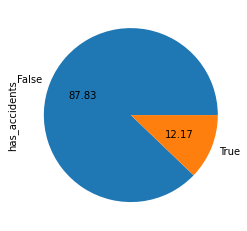

In [15]:
# Create a pie chart to compare the 'has_accidents' column
ax1 = df_pd.groupby('has_accidents').size().plot(kind='pie', autopct='%.2f')
ax1.set_ylabel('has_accidents')

Text(0, 0.5, 'is_cpo')

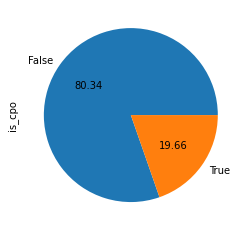

In [16]:
# Create a pie chart to compare the 'is_cpo' column
ax2 = df_pd.groupby('is_cpo').size().plot(kind='pie', autopct='%.2f')
ax2.set_ylabel('is_cpo')

Text(0, 0.5, 'is_oemcpo')

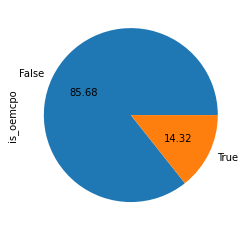

In [17]:
# Create a pie chart to compare the 'is_oemcpo' column
ax3 = df_pd.groupby('is_oemcpo').size().plot(kind='pie', autopct='%.2f')
ax3.set_ylabel('is_oemcpo')

Text(0, 0.5, 'is_new')

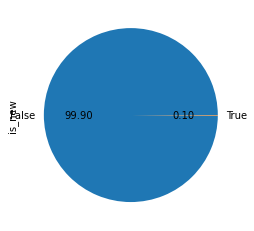

In [18]:
# Create a pie chart to compare the 'is_new' column
ax4 = df_pd.groupby('is_new').size().plot(kind='pie', autopct='%.2f')
ax4.set_ylabel('is_new')

Text(0, 0.5, 'isCab')

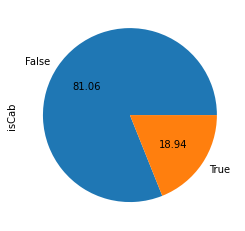

In [19]:
# Create a pie chart to compare the 'isCab' column
ax5 = df_pd.groupby('isCab').size().plot(kind='pie', autopct='%.2f')
ax5.set_ylabel('isCab')

Other than doing the basic exploration of the dataset, we also need to do in depth exploration on the "most important" column, which is the 'price' column. This is because the 'price' column will be used as the target variable. Thus, it is good to explore it in detail.

array([[<Axes: title={'center': 'price'}>]], dtype=object)

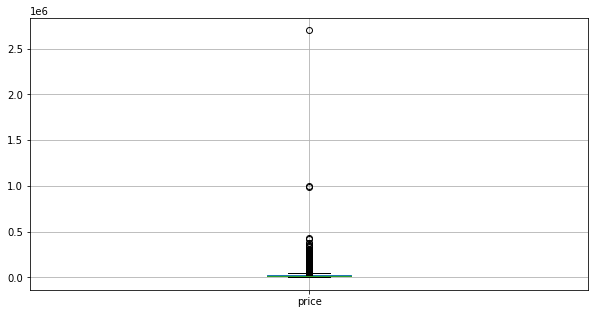

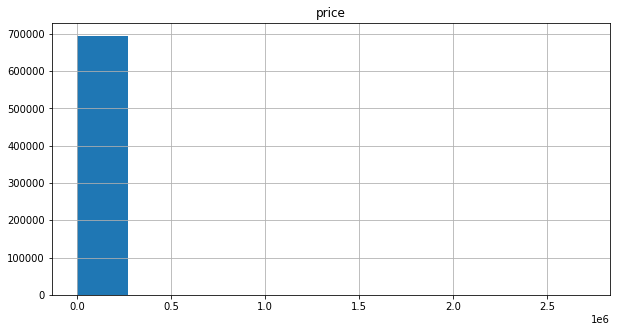

In [20]:
# Create a boxplot of the 'price' column
df_pd.boxplot('price', figsize = (10,5))

# Create a histogram of the 'price' column
df_pd.hist('price', figsize = (10,5))

From the boxplot, it can be seen that the 'price' column has a really wide range of values, thus resulting in a lot of outliers. However, those data points are true outliers as the price of a used car varies a lot, depending on the features and conditions. Therefore, removing those outliers are not recommended.

Next, from the histogram, it can be seen that the distribution is heavily skewed to the right. Interestingly, when comparing the mean and median of the 'price' column in the summary statistic table, the values are not significantly different, which is only by 2,500. The skewness may be caused by the large number of outliers, especially the ones that are greater than upper boundary. The large number of "big numbers" may pull the data distribution into a right skewed one.

# MACHINE LEARNING

## FEATURIZATION

Before using the data for training a machine learning model, we need to modidy the data first. The Linear Regression model in the PySpark can only take numeric values as the input. Therefore, we need to do some transformation on the string columns (Note: the model can also accept Boolean values as **True** is equal to 1 and **False** is equal to 0). The transformation consists of: 

* **String Indexing**: to transform the categories into indices
* **One Hot Encoding (OHE)**: change the string indices to binary vectors to avoid ordinality problems

Then after transforming all the string columns into numeric values, we also need to assemble all of the input columns (features) into a single vector column as the model only accept a single vector column as the input.

Lastly, because the numeric columns have wide range of values, it is better to rescale those values into a common scale between 0 and 1 to macth the binary values from the OHE results and the Boolean columns. 

In [21]:
# Separate the string, numeric, and boolean columns
string_columns = [field for (field, dataType) in df.dtypes
                    if ((dataType == "string") & (field != "vin"))]
numeric_columns = [field for (field, dataType) in df.dtypes
                    if ((dataType in ["int", "double"]) & (field not in ["price", "log_price"]))]
boolean_columns = [field for (field, dataType) in df.dtypes
                    if dataType == "boolean"]

In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler

# Define the output column names
index_output_cols = [f'{x}_index' for x in string_columns]
ohe_output_cols = [f'{x}_ohe' for x in string_columns]

# Do string indexing on the string columns
# This will transform the categories into indices
indexer = StringIndexer(inputCols = string_columns, 
                        outputCols = index_output_cols).setHandleInvalid("keep")

# Do one hot encoding on the indexed columns
# This will transform the indices into binary vectors
encoder = OneHotEncoder(inputCols = index_output_cols, 
                        outputCols = ohe_output_cols)

# Assemble all the predictors into a single vector column
assembler_input_cols = ohe_output_cols + numeric_columns + boolean_columns
assembler = VectorAssembler(
    inputCols = assembler_input_cols,
    outputCol = 'features')

# Do rescaling on the numeric columns
scaler = MinMaxScaler(inputCol = "features",
                      outputCol = "scaled_features")

After the transformation, notice that all of the features' values are between 0 and 1, thus it also better to transform the target variable, 'price', into a smaller value also. This will also help with feature selection as the resulting coefficients obtained from the model should not be too big (easier to eliminate if it is too small).

In [23]:
from pyspark.sql.functions import log10

# Transform the label column into using a logarithmic transformation
df = df.withColumn("log_price", log10(df.price))

## MODEL CREATION

The machine learning method that we are going to use is Linear Regression. However, because we also have a lot of features, thus we considered to use a **Regularization** method to avoid overfitting. Therefore, here, we will try to compare three types of method:

* No regularization
* With regularization using the LASSO model
* With regularization using the Ridge model

In [24]:
# Divide the data into training and test
train, tests = df.randomSplit([0.5, 0.5], 42)

### NO REGULARIZATION

In [25]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the linear regression model
reg = LinearRegression(labelCol = "log_price", featuresCol = "scaled_features")

# Create the pipeline
reg_pipeline = Pipeline(stages = [indexer, encoder, assembler, scaler, reg])

# Build a parameter grid for the hyperparameter tuning step
# Because we do not use regularization, the the regParam should be zero
reg_param_grid = ParamGridBuilder() \
    .addGrid(reg.regParam, [0.0]) \
    .build()

# Define the evaluation method for the hyperparameter tuning
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "log_price", metricName = "rmse")

# Time the start of the process
print("Create k-fold cross-validation model for no-regularization at - ", datetime.now())

# Create the k-fold cross-validation model
reg_cross_validator = CrossValidator(estimator = reg_pipeline,
                                 evaluator = evaluator,
                                 estimatorParamMaps = reg_param_grid,
                                 numFolds = 5,
                                 parallelism = 2,
                                 seed = 42)

# Time the end of the process
print("Stop at - ", datetime.now())

Create k-fold cross-validation model for no-regularization at -  2023-11-09 21:19:49.525612
Stop at -  2023-11-09 21:19:49.525989


In [26]:
# Time the start of the process
print("Start training k-fold cross-validation for no-regularization at - ", datetime.now())

# Train the model using the training data
reg_cv_model = reg_cross_validator.fit(train)

# Time the end of the process
print("Stop at - ", datetime.now())

# Get the best model from the cross-validation
reg_model = reg_cv_model.bestModel

Start training k-fold cross-validation for no-regularization at -  2023-11-09 21:19:49.531199
Stop at -  2023-11-09 21:26:35.313534


### LASSO

In [27]:
# Define the linear regression model
# Bacause here we use LASSO model, set the 'elasticNetParam' argument equal to 1
lasso = LinearRegression(labelCol = "log_price", featuresCol = "scaled_features", elasticNetParam = 1)

# Create the pipeline
lasso_pipeline = Pipeline(stages = [indexer, encoder, assembler, scaler, lasso])

# Build a parameter grid for the hyperparameter tuning step
# Here, we will test 4 level of the regularization rate (regParam)
# We will use the cross-validation method to find the best parameter
lasso_param_grid = ParamGridBuilder() \
    .addGrid(lasso.regParam, [0.001, 0.01, 0.1, 1.0]) \
    .build()

# Time the start of the process
print("Create k-fold cross-validation model for LASSO at - ", datetime.now())

# Create the k-fold cross-validation model
lasso_cross_validator = CrossValidator(estimator = lasso_pipeline,
                                 estimatorParamMaps = lasso_param_grid,
                                 evaluator = evaluator,
                                 numFolds = 5,
                                 parallelism = 2,
                                 seed = 42)

# Time the end of the process
print("Stop at - ", datetime.now())

Create k-fold cross-validation model for LASSO at -  2023-11-09 21:26:35.375435
Stop at -  2023-11-09 21:26:35.378156


In [28]:
# Time the start of the process
print("Start training k-fold cross-validation for LASSO at - ", datetime.now())

# Train the model using the training data
lasso_cv_model = lasso_cross_validator.fit(train)

# Time the end of the process
print("Stop at - ", datetime.now())

# Get the best model from the cross-validation
lasso_model = lasso_cv_model.bestModel

Start training k-fold cross-validation for LASSO at -  2023-11-09 21:26:35.432731
Stop at -  2023-11-09 21:33:34.766520


### RIDGE

In [29]:
# Define the linear regression model
# Bacause here we use Ridge model, set the 'elasticNetParam' argument equal to 0
ridge = LinearRegression(labelCol = "log_price", featuresCol = "scaled_features", elasticNetParam = 0)

# Create the pipeline
ridge_pipeline = Pipeline(stages = [indexer, encoder, assembler, scaler, ridge])

# Build a parameter grid for the hyperparameter tuning step
# Here, we will test 4 level of the regularization rate (regParam)
# We will use the cross-validation method to find the best parameter
ridge_param_grid = ParamGridBuilder() \
    .addGrid(ridge.regParam, [0.001, 0.01, 0.1, 1.0]) \
    .build()

# Time the start of the process
print("Create k-fold cross-validation model for Ridge at - ", datetime.now())

# Create the k-fold cross-validation model
ridge_cross_validator = CrossValidator(estimator = ridge_pipeline,
                                 estimatorParamMaps = ridge_param_grid,
                                 evaluator = evaluator,
                                 numFolds = 5,
                                 parallelism = 2,
                                 seed = 42)

# Time the end of the process
print("Stop at - ", datetime.now())

Create k-fold cross-validation model for Ridge at -  2023-11-09 21:33:34.872161
Stop at -  2023-11-09 21:33:34.872788


In [30]:
# Time the start of the process
print("Start training k-fold cross-validation for Ridge at - ", datetime.now())

# Train the model using the training data
ridge_cv_model = ridge_cross_validator.fit(train)

# Time the end of the process
print("Stop at - ", datetime.now())

# Get the best model from the cross-validation
ridge_model = ridge_cv_model.bestModel

Start training k-fold cross-validation for Ridge at -  2023-11-09 21:33:34.910608
Stop at -  2023-11-09 21:39:44.540909


## MODEL EVALUATION

After creating the model, then the next step is to evaluate the model. For the evaluation criteria, here we use RMSE (Root Mean Squared Error) and R2.

In [31]:
# Split the test data into 10 subsets to check whether the model is overfitted or not
split_test = tests.randomSplit([0.1]*10, 42)

# Create empty containers to saved the evaluation results
rmse = []
r2 = []

for i in range(len(split_test)):
    # Define the test data
    test = split_test[i]
    
    # Test the no regularization model on the test data
    reg_pred = reg_model.transform(test)
    reg_pred = reg_pred.withColumn("price_pred", 10**reg_pred.prediction)

    # Test the LASSO model on the test data
    lasso_pred = lasso_model.transform(test)
    lasso_pred = lasso_pred.withColumn("price_pred", 10**lasso_pred.prediction)
    
    # Test the Ridge model on the test data
    ridge_pred = ridge_model.transform(test)
    ridge_pred = ridge_pred.withColumn("price_pred", 10**ridge_pred.prediction)
    
    # Define the evaluation method
    evaluation = RegressionEvaluator(predictionCol = "price_pred", labelCol = "price", metricName = "rmse")

    # Calculate the RMSE for all methods and save the result
    rmse.append({"reg": evaluation.evaluate(reg_pred),
    "lasso": evaluation.evaluate(lasso_pred),
    "ridge": evaluation.evaluate(ridge_pred)})

    # Calculate the R2 for all methods and save the result
    r2.append({"reg": evaluation.setMetricName("r2").evaluate(reg_pred),
    "lasso": evaluation.setMetricName("r2").evaluate(lasso_pred),
    "ridge": evaluation.setMetricName("r2").evaluate(ridge_pred)})

After calculating all the evaluation criteria, then we need to compare the results from each model.

In [32]:
# Create two dataframes, both from the RMSE results and R2 results
# To make it easier to compare the results
rmse_validation = spark.createDataFrame(rmse)
r2_validation = spark.createDataFrame(r2)

rmse_validation.show()
r2_validation.show()

/home/student/.local/lib/python3.8/site-packages/pyspark/sql/session.py:378: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+------------------+------------------+------------------+
|             lasso|               reg|             ridge|
+------------------+------------------+------------------+
| 4739.265707058157| 4625.039167401189| 4621.462722564221|
| 4988.899534200671| 4853.560004423535| 4853.772799934557|
| 5032.832293203693| 4864.532870857217|  4867.89260513913|
| 4813.180185489388|  4665.05973508611| 4664.093001666433|
|15159.436028017739|15111.842388195711|15112.224154259296|
| 5058.670681320016| 4998.546577330865| 4994.442154561905|
| 4707.233223717964| 4605.791944521248| 4603.125513300127|
| 4822.300283156026|4699.3868100958225| 4700.168956059427|
| 5011.375872310145| 4853.285113931833|4855.1524669726705|
|  6999.17976256856| 6948.685168650682| 6947.542768345361|
+------------------+------------------+------------------+

+------------------+------------------+------------------+
|             lasso|               reg|             ridge|
+------------------+------------------+----------------

From the comparison table above, overall there are **no significant difference** of the RMSE and R2 values between each model and subset, except for subset number 5 and 10. First, we need to investigate the cause of that significant difference.

One possible cause is because the test data contains some **extreme outliers**, especially with a very large target variable value. This may cause the resulting difference to be large as the model cannot accomodate those "big" values.

Therefore, we need to compare the data distribution of the training data, test data number 5, and test data number 10.

<Axes: >

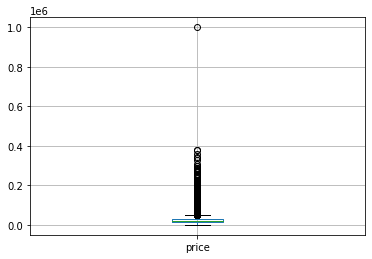

In [33]:
train.toPandas().boxplot('price')

<Axes: >

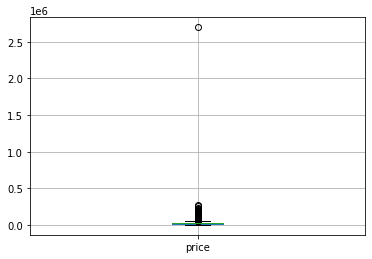

In [34]:
split_test[4].toPandas().boxplot('price')

<Axes: >

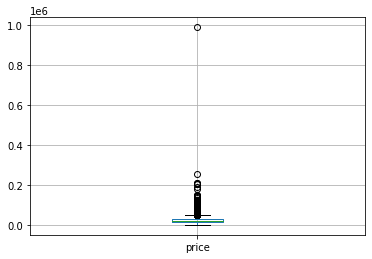

In [35]:
split_test[9].toPandas().boxplot('price')

In [36]:
train.select('price').summary().show()
split_test[4].select('price').summary().show()
split_test[9].select('price').summary().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           347395|
|   mean|24026.13024496611|
| stddev|12113.35388334817|
|    min|            484.0|
|    25%|          16130.0|
|    50%|          21500.0|
|    75%|          29993.0|
|    max|         999995.0|
+-------+-----------------+

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             34503|
|   mean|24103.888736051937|
| stddev|18829.745191028436|
|    min|             484.0|
|    25%|           16000.0|
|    50%|           21503.0|
|    75%|           29990.0|
|    max|         2698500.0|
+-------+------------------+

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             34968|
|   mean| 23970.31338452299|
| stddev|12691.800257632383|
|    min|             495.0|
|    25%|           16177.0|
|    50%|           21495.0|
|    75%|           29995.0|
|    max|          98851

Notice that subset number 5 and 10 (index 4 and 9, respectively) have an extreme outlier where the price is around or more than 1 million USD. Even though the training data also contain an extreme outlier, there is only one point of that data, thus it may not considered much when training the model.

Therefore, let's check the evaluation metrics if we remove those outliers.

In [37]:
# Create new empty containers to saved the new evaluation results
rmse_2 = []
r2_2 = []

# Retest the subset no 5 and 10 while removing the extreme outlier
for i in [4,9]:
    # Define the test data
    test = split_test[i]
    
    # Filter out the extreme outlier
    test = test.filter(test.price < 900000)
    
    
    # Test the no regularization model on the test data
    reg_pred = reg_model.transform(test)
    reg_pred = reg_pred.withColumn("price_pred", 10**reg_pred.prediction)

    # Test the LASSO model on the test data
    lasso_pred = lasso_model.transform(test)
    lasso_pred = lasso_pred.withColumn("price_pred", 10**lasso_pred.prediction)
    
    # Test the Ridge model on the test data
    ridge_pred = ridge_model.transform(test)
    ridge_pred = ridge_pred.withColumn("price_pred", 10**ridge_pred.prediction)
    
    # Define the evaluation method
    evaluation = RegressionEvaluator(predictionCol = "price_pred", labelCol = "price", metricName = "rmse")

    # Calculate the RMSE for all methods
    rmse_2.append({"reg": evaluation.evaluate(reg_pred),
    "lasso": evaluation.evaluate(lasso_pred),
    "ridge": evaluation.evaluate(ridge_pred)})

    # Calculate the R2 for all methods
    r2_2.append({"reg": evaluation.setMetricName("r2").evaluate(reg_pred),
    "lasso": evaluation.setMetricName("r2").evaluate(lasso_pred),
    "ridge": evaluation.setMetricName("r2").evaluate(ridge_pred)})

# Create new dataframes to show the new evaluation results
rmse_validation_2 = spark.createDataFrame(rmse_2)
r2_validation_2 = spark.createDataFrame(r2_2)

rmse_validation_2.show()
r2_validation_2.show()

/home/student/.local/lib/python3.8/site-packages/pyspark/sql/session.py:378: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----------------+-----------------+-----------------+
|            lasso|              reg|            ridge|
+-----------------+-----------------+-----------------+
|4789.668140863634| 4640.22323138043|4641.183455255928|
| 4649.80589827395|4571.456815751202| 4570.21154561114|
+-----------------+-----------------+-----------------+

+------------------+------------------+------------------+
|             lasso|               reg|             ridge|
+------------------+------------------+------------------+
|0.8442037737447807|0.8537742577685418|0.8537137331042295|
|0.8392211977078786|0.8445937846404321|0.8446784387756278|
+------------------+------------------+------------------+



After redoing the evaluation for subset number 5 and 10 while removing the extreme outliers, notice that the metrics' values are quite similar with the other 8 subsets. Therefore, we can safely conclude that the model is **not overfitted**. 

However, it is important to also note that the model cannot handle the prediction where the price is really big (assumed to be more than 50,000 USD based on the distribution of the training data).

Now, let's compare the overall evaluation metrics of each model by calculating the average and the standard deviation.

In [38]:
# Remove the original subset number 5 and 10
# Append the new calculation
rmse_validation = rmse_validation.filter(rmse_validation.reg < 6000).union(rmse_validation_2)
r2_validation = r2_validation.filter(r2_validation.reg > 0.7).union(r2_validation_2)

rmse_validation.show()
r2_validation.show()

+-----------------+------------------+------------------+
|            lasso|               reg|             ridge|
+-----------------+------------------+------------------+
|4739.265707058157| 4625.039167401189| 4621.462722564221|
|4988.899534200671| 4853.560004423535| 4853.772799934557|
|5032.832293203693| 4864.532870857217|  4867.89260513913|
|4813.180185489388|  4665.05973508611| 4664.093001666433|
|5058.670681320016| 4998.546577330865| 4994.442154561905|
|4707.233223717964| 4605.791944521248| 4603.125513300127|
|4822.300283156026|4699.3868100958225| 4700.168956059427|
|5011.375872310145| 4853.285113931833|4855.1524669726705|
|4789.668140863634|  4640.22323138043| 4641.183455255928|
| 4649.80589827395| 4571.456815751202|  4570.21154561114|
+-----------------+------------------+------------------+

+------------------+------------------+------------------+
|             lasso|               reg|             ridge|
+------------------+------------------+------------------+
|0.8417185

In [39]:
from pyspark.sql.functions import mean, stddev

# Calculate the average and the standard deviation of the metrics
rmse_validation.select(mean(rmse_validation.reg), stddev(rmse_validation.reg), 
                       mean(rmse_validation.lasso), stddev(rmse_validation.lasso),
                       mean(rmse_validation.ridge), stddev(rmse_validation.ridge)).show()

r2_validation.select(mean(r2_validation.reg), stddev(r2_validation.reg), 
                       mean(r2_validation.lasso), stddev(r2_validation.lasso),
                       mean(r2_validation.ridge), stddev(r2_validation.ridge)).show()

+-----------------+------------------+-----------------+------------------+------------------+------------------+
|         avg(reg)|  stddev_samp(reg)|       avg(lasso)|stddev_samp(lasso)|        avg(ridge)|stddev_samp(ridge)|
+-----------------+------------------+-----------------+------------------+------------------+------------------+
|4737.688227077945|143.32798264271725|4861.323181959365|148.88818684530133|4737.1505221065545|143.73872838789856|
+-----------------+------------------+-----------------+------------------+------------------+------------------+

+------------------+------------------+------------------+-------------------+------------------+-------------------+
|          avg(reg)|  stddev_samp(reg)|        avg(lasso)| stddev_samp(lasso)|        avg(ridge)| stddev_samp(ridge)|
+------------------+------------------+------------------+-------------------+------------------+-------------------+
|0.8291382717706637|0.0434239291602262|0.8211839167902116|0.042179717379522

From the comparison above, it can be seen that the **Ridge model** has the lowest RMSE and highest R2 value.

# FEATURE SELECTION

One of our goal in this project is also for determining which features have big impact on the price. This can be evaluated by comparing the coefficients in the model. Now, let's see the coefficients from each model

In [40]:
reg_coeff = reg_model.stages[-1].coefficients
lasso_coeff = lasso_model.stages[-1].coefficients
ridge_coeff = ridge_model.stages[-1].coefficients

numeric_metadata = reg_pred.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
binary_metadata = reg_pred.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('binary')

feature_names = binary_metadata + numeric_metadata

In [41]:
reg_feature_importance = []

for idx in range(len(feature_names)):
    reg_feature_importance.append((feature_names[idx]["name"], reg_coeff[idx]))

reg_feature_importance =sorted(reg_feature_importance, key=lambda x: abs(x[1]), reverse=True)

for each in reg_feature_importance:
    print(each)

('year', 1.0523767513216964)
('mileage', -0.6543871075416312)
('horsepower', 0.5546259775911406)
('city_fuel_economy', 0.5505353899073014)
('highway_fuel_economy', -0.42128018313291277)
('torque', 0.3413681034508074)
('engine_cylinders_ohe_V12', 0.3037879141116258)
('franchise_make_ohe_McLaren', 0.2645883305433444)
('engine_cylinders_ohe_W12 Flex Fuel Vehicle', 0.2542560034394101)
('franchise_make_ohe_Ferrari', 0.21248019806760404)
('engine_cylinders_ohe_W12', 0.154975783942023)
('engine_cylinders_ohe_V10', -0.15285401417311345)
('franchise_make_ohe_Bentley', 0.15264440032913326)
('franchise_make_ohe_Rolls-Royce', 0.11441643902514796)
('franchise_make_ohe_Pagani', 0.10673275251624237)
('franchise_make_ohe_Rover', 0.09806773993340728)
('engine_displacement', 0.0900582337724402)
('engine_cylinders_ohe_I6 Hybrid', -0.08915681418863702)
('franchise_make_ohe_Mercedes-Benz', 0.08633304067768324)
('franchise_make_ohe_Land Rover', 0.08553196837465349)
('franchise_make_ohe_Jaguar', 0.0854309656

In [42]:
lasso_feature_importance = []

for idx in range(len(feature_names)):
    lasso_feature_importance.append((feature_names[idx]["name"], lasso_coeff[idx]))

lasso_feature_importance =sorted(lasso_feature_importance, key=lambda x: abs(x[1]), reverse=True)

for each in lasso_feature_importance:
    print(each)

('year', 1.0518717779921376)
('mileage', -0.6567315970928455)
('horsepower', 0.5561637098896989)
('torque', 0.3168233380446597)
('engine_cylinders_ohe_V12', 0.31668084893133097)
('franchise_make_ohe_McLaren', 0.17950970253700496)
('engine_cylinders_ohe_W12', 0.15683374820042478)
('franchise_make_ohe_Bentley', 0.12011154459496645)
('highway_fuel_economy', -0.09996250154356981)
('franchise_make_ohe_Mercedes-Benz', 0.0939509050620777)
('franchise_make_ohe_Rolls-Royce', 0.08103083476836827)
('franchise_make_ohe_Land Rover', 0.0798799417524047)
('franchise_make_ohe_Lexus', 0.07391055490445322)
('franchise_make_ohe_Jaguar', 0.06916493748823602)
('engine_cylinders_ohe_V6 Flex Fuel Vehicle', -0.06504359654262437)
('franchise_make_ohe_BMW', 0.06366747219498217)
('engine_cylinders_ohe_W12 Flex Fuel Vehicle', 0.05863884234376727)
('city_fuel_economy', 0.05817678177739476)
('franchise_make_ohe_Audi', 0.05126671616991361)
('engine_cylinders_ohe_V6 Biodiesel', 0.04679465469763692)
('fuel_type_ohe_Bi

In [43]:
from numpy import count_nonzero

# Print the total number of coefficients
print(len(lasso_coeff))

# Print the number of non-zero coefficients
print(count_nonzero(lasso_coeff))

133
79


In [44]:
ridge_feature_importance = []

for idx in range(len(feature_names)):
    ridge_feature_importance.append((feature_names[idx]["name"], ridge_coeff[idx]))

ridge_feature_importance =sorted(ridge_feature_importance, key=lambda x: abs(x[1]), reverse=True)

for each in ridge_feature_importance:
    print(each)

('year', 1.0465242574727511)
('mileage', -0.6555847550901114)
('horsepower', 0.5369401459497758)
('city_fuel_economy', 0.46335472064525546)
('highway_fuel_economy', -0.3581526713125679)
('torque', 0.343681276902793)
('engine_cylinders_ohe_V12', 0.3135314228977402)
('franchise_make_ohe_McLaren', 0.2649550994739928)
('engine_cylinders_ohe_W12 Flex Fuel Vehicle', 0.26142760337515286)
('franchise_make_ohe_Ferrari', 0.21283984513646995)
('engine_cylinders_ohe_W12', 0.16444269521552896)
('franchise_make_ohe_Bentley', 0.15183522312091194)
('engine_cylinders_ohe_V10', -0.1436677387762869)
('franchise_make_ohe_Rolls-Royce', 0.11477818665202817)
('franchise_make_ohe_Pagani', 0.10558410222352867)
('franchise_make_ohe_Rover', 0.0980843829503803)
('engine_cylinders_ohe_I6 Hybrid', -0.0883693998096315)
('franchise_make_ohe_Mercedes-Benz', 0.08712053086153615)
('franchise_make_ohe_Jaguar', 0.08612880442495892)
('franchise_make_ohe_Land Rover', 0.08577618616662033)
('engine_displacement', 0.0767341060

Notice that in the LASSO model, some features have the zero valued coefficient. This is because the LASSO model "encourage" the unimportant variables (near zero coefficients) to have zero for their coefficient, whereas for no-regularization and Ridge model, the value never reached zero.

Therefore, the LASSO model can be used to help eliminating the unimportant features from the equation to avoid overfitting.

# Conclusion

Even though the Ridge model has the best evaluation metrics (lowest RMSE and highest R2), the LASSO model can help to eliminate the unimportants features by setting their coefficients to zero. Therefore, for our case we decided to choose the LASSO model as the evaluation metrics are not too different but can help with the feature selection. In conclusion, here is our final model.

In [46]:
print('----- FINAL MODEL -----')
print('Intercept: {0:.5f}'.format(lasso_model.stages[-1].intercept))

for each in lasso_feature_importance:
    if each[1] != 0:
        print('{0}: {1:.5f}'.format(each[0], each[1]))

----- FINAL MODEL -----
Intercept: 3.35151
year: 1.05187
mileage: -0.65673
horsepower: 0.55616
torque: 0.31682
engine_cylinders_ohe_V12: 0.31668
franchise_make_ohe_McLaren: 0.17951
engine_cylinders_ohe_W12: 0.15683
franchise_make_ohe_Bentley: 0.12011
highway_fuel_economy: -0.09996
franchise_make_ohe_Mercedes-Benz: 0.09395
franchise_make_ohe_Rolls-Royce: 0.08103
franchise_make_ohe_Land Rover: 0.07988
franchise_make_ohe_Lexus: 0.07391
franchise_make_ohe_Jaguar: 0.06916
engine_cylinders_ohe_V6 Flex Fuel Vehicle: -0.06504
franchise_make_ohe_BMW: 0.06367
engine_cylinders_ohe_W12 Flex Fuel Vehicle: 0.05864
city_fuel_economy: 0.05818
franchise_make_ohe_Audi: 0.05127
engine_cylinders_ohe_V6 Biodiesel: 0.04679
fuel_type_ohe_Biodiesel: 0.04679
wheel_system_ohe_FWD: -0.04507
engine_cylinders_ohe_I4 Flex Fuel Vehicle: -0.04048
isCab: -0.03805
franchise_make_ohe_Dodge: -0.03524
franchise_make_ohe_Maserati: 0.03427
franchise_make_ohe_Volvo: 0.03289
fuel_type_ohe_Diesel: 0.03226
wheelbase: -0.03144
e